# Sea ice extent: Weddell Sea region 

Data prepared by Caroline Holmes (BAS)

In [1]:
!pip install seaborn

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import xarray as xr
import pandas as pd
import os

Next, select a few years to plot, along with the colours to use for those lines

In [3]:
years_to_plot = [2013, 2016, 2020]
colors_for_lines = ["black", "red", "green"]

First, import the daily, mean, and standard deviation for the Weddell Sea region sea ice extent

In [4]:
weddell_daily = xr.open_dataset('obs_NASATeam_historical_1_siextentWeddelldaily.nc')
weddell_mean = xr.open_dataset('obs_NASATeam_historical_1_siextentWeddelldaily_mean_19912020.nc')
weddell_std = xr.open_dataset('obs_NASATeam_historical_1_siextentWeddelldaily_sd_19912020.nc')

Next, examine the properties of the daily dataset

In [5]:
weddell_daily

<xarray.Dataset>
Dimensions:         (time: 13757)
Coordinates:
  * time            (time) datetime64[ns] 1978-10-26T12:00:00 ... 2020-12-31T...
    day_of_month    (time) int64 ...
    month           (time) int64 ...
    year            (time) int64 ...
Data variables:
    sea_ice_extent  (time) float64 ...
Attributes:
    areas source file:   /home/users/cholmes02/data/seaice_obs/pss25area_v3.dat
    calculated on grid:  polar stereo
    iris_version:        2.4.0
    python_version:      3.7.9
    sic source file:     /gws/nopw/j04/bas_climate/data/observations/sea_ice/...
    source frequency:    daily
    Conventions:         CF-1.7

### Plot of daily sea ice extent in the Weddell Sea 

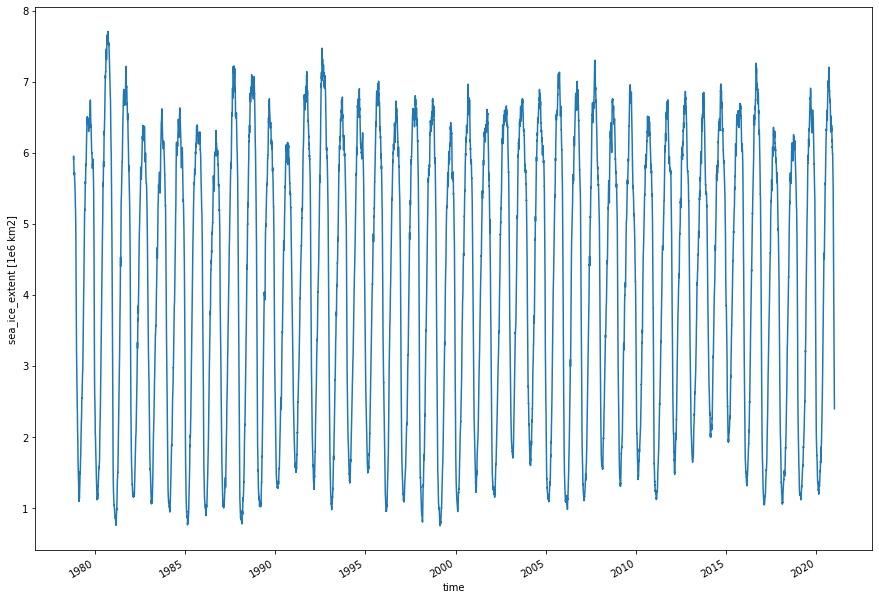

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
weddell_daily['sea_ice_extent'].plot(x='time')

### Climatological mean sea ice extent

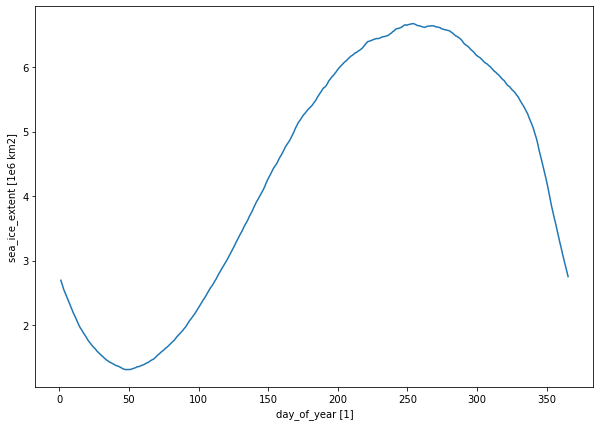

In [7]:
fig, ax = plt.subplots(figsize=(10,7))
weddell_mean['sea_ice_extent'].plot(x='day_of_year')

## Examine Antarctic-wide sea ice extent

In [8]:
# load antarctic climatology and daily values
antarctic_climatology = pd.read_csv('S_seaice_extent_climatology_1981-2010_v3.0.csv', skiprows=1)
antarctic_daily = pd.read_csv('S_seaice_extent_daily_v3.0.csv', skiprows=[1])

# remove whitespace from column names
antarctic_climatology.columns = antarctic_climatology.columns.str.replace(' ', '')
antarctic_daily.columns = antarctic_daily.columns.str.replace(' ', '')

# this creates the DataFrame that can be used to calculate day of year
df_date = pd.DataFrame({'year': antarctic_daily.Year.values,
                        'month': antarctic_daily.Month.values,
                        'day': antarctic_daily.Day.values})

# the .dt.dayofyear function calculates day of year
DOY = pd.to_datetime(df_date).dt.dayofyear

# insert day of year (DOY) as a new column 
antarctic_daily.insert(0,"DOY",DOY)

## Plot values for Weddell Sea

### Plotting prerequisites

In [9]:
df = weddell_daily.to_dataframe()

In [10]:
# helper function to add arrows and text
def annotate_years(years_to_plot, colors_for_lines, ax=None):
    delta = 0
    i = -1
    for year in years_to_plot:
        delta = delta + 20 
        i = i + 1
        nowData=df[df.year==int(year)]
        nowExtent=nowData['sea_ice_extent'].values
        xy_x = min(50+delta,nowExtent.size)-1
        xy_y = nowExtent[xy_x]
        nowColor = str(colors_for_lines[i])
        ax.annotate(year,
                    (xy_x,xy_y),
                    (xy_x-50,xy_y+2),
                    arrowprops=dict(facecolor=nowColor, shrink=0.05),
                    fontsize='xx-large',
                    color=nowColor)
    return(ax)

In [11]:
# two standard deviations
x = weddell_mean.day_of_year
y1 = weddell_mean.sea_ice_extent - 2.0*weddell_std.sea_ice_extent
y2 = weddell_mean.sea_ice_extent + 2.0*weddell_std.sea_ice_extent

# one standard deviation
x = weddell_mean.day_of_year
y3 = weddell_mean.sea_ice_extent - weddell_std.sea_ice_extent
y4 = weddell_mean.sea_ice_extent + weddell_std.sea_ice_extent

# mean
ybar = weddell_mean.sea_ice_extent

# example of converting to dataframe, isolating a year
#df[df.year==2020].sea_ice_extent

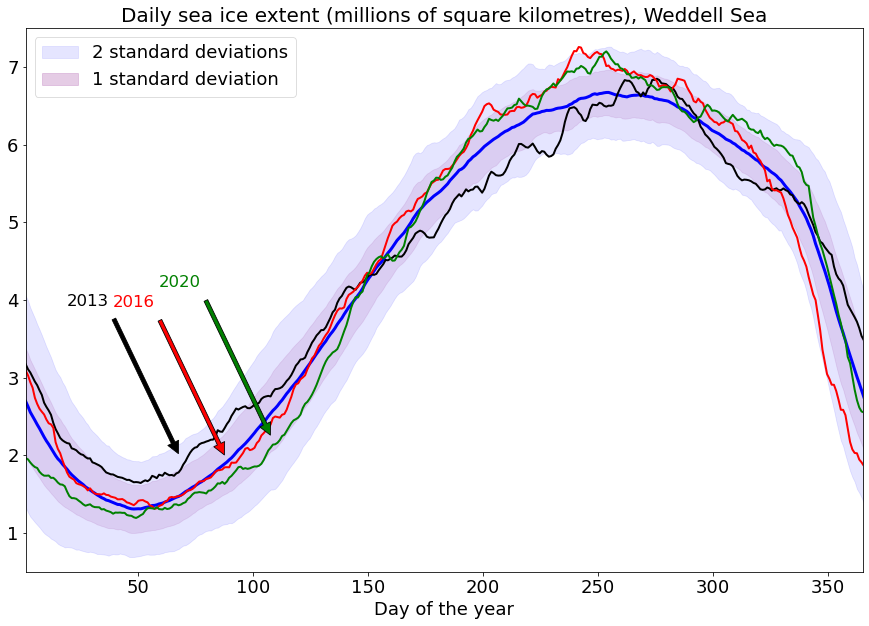

In [12]:
# plot data
fig, ax = plt.subplots(figsize=(15,10))
sns.set_context("paper")
ax.fill_between(x, y1, y2, color='blue', alpha=.1)
ax.fill_between(x, y3, y4, color='purple', alpha=.1)
ax.plot(x, ybar, color='blue', linewidth=3.0)

# plot individual lines for individual years
year_count = -1
for nyear in years_to_plot:
    year_count = year_count + 1
    yline = df[df.year==nyear].sea_ice_extent.values
    max_length = np.minimum(x.size,yline.size)
    ax.plot(x[0:max_length], yline[0:max_length], color=colors_for_lines[year_count], linewidth=2.0)
    
# manual legend
purple_patch = mpatches.Patch(color='purple', label='1 standard deviation', alpha=.2)
blue_patch = mpatches.Patch(color='blue', label='2 standard deviations', alpha=.1)
plt.legend(handles=[blue_patch,purple_patch], fontsize=18)

# tick label font size
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# title, xlabel, and ylabel
plt.title("Daily sea ice extent (millions of square kilometres), Weddell Sea", fontsize=20)
plt.xlabel("Day of the year", fontsize=18)
plt.ylabel("")

# limits of x and y axes
plt.xlim([1,365])
plt.ylim([0.5, 7.5])

# call helper function to annotate years
annotate_years(years_to_plot, colors_for_lines, ax=ax)

# customize (white, dark, whitegrid, darkgrid, ticks)
sns.set_style("darkgrid")

The year 2013 is interesting: it was a bit high in the summer and early spring, but a bit low in autumn and early winter. This is in contrast with the Antarctic-wide extent, which was anomalously high for most of 2013. As suspected, sea ice extent in the Weddell Sea does not necessarily behave in the same way as the Antarctic-wide sea ice extent. 

In [13]:
# save figure
fig.savefig('weddell_sea_ice_extent.pdf', format='pdf')

# it's helpful to run "pdfcrop" or a similar command line tool on this PDF afterwards, if available